# Stationary Diffusion Equations

In this tutorial we will consider stationary 1D diffusion with a source term. The governing equation is:

$$-\mathrm{div}(D \, \mathrm{grad}(c)) = f$$

In `PyMRM`, the discretized form can be expressed as:
```python
- div_mat @ (conv_mat @ c - D * grad_mat @ c) = f
```
Here `div_mat` and `grad_mat` are matrices that approximate the differential operators $\mathrm{div}$ and $\mathrm{grad}$, respectively.

<a id="stationary-diffusion-code"></a>
#### Stationary Diffusion Code

Below is the implementation of the stationary diffusion problem.

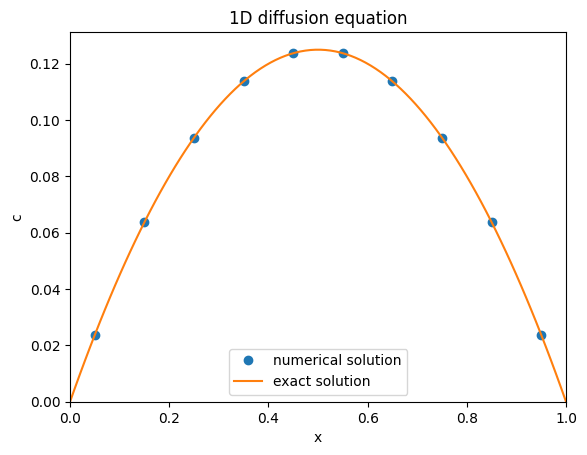

In [31]:
from pymrm import construct_grad, construct_div
from matplotlib import pyplot as plt
import numpy as np
import scipy.sparse.linalg as sla

L = 1.0 # length of the domain
n_c = 10 # number of cells in the computational domain
shape_c = (n_c,) # shape array c
f = -np.ones(shape_c) # source term

x_f = np.linspace(0, L, shape_c[0]+1) # location of cell faces
x_c = 0.5*(x_f[:-1] + x_f[1:]); # location of cell centers
bc = ({'a':0,'b':1, 'd':0}, {'a':0, 'b':1, 'd':0}) # boundary conditions specification

div_mat = construct_div(shape_c, x_f) # Divergence matrix
grad_mat, grad_bc = construct_grad(shape_c, x_f, x_c, bc=bc) # Gradient matrix
lapl_mat = div_mat @ grad_mat # Laplacian matrix
rhs_vec = f.reshape((-1,1)) - div_mat @ grad_bc # right-hand side vector

c = sla.spsolve(lapl_mat, rhs_vec) # solve the PDE

# Plotting the results
plt.plot(x_c, c,'o', label='numerical solution')
x_fine = np.linspace(0, L, 100) # fine grid for plotting
plt.plot(x_fine, 0.5*(x_fine*(L-x_fine)), label='exact solution')
plt.xlabel('x')
plt.ylabel('c')
plt.xlim(0, L)
plt.ylim(0, None)
plt.title('1D diffusion equation')
plt.legend()
plt.show()


### Detailed Explanation: Cell-Centered Quantities

In `PyMRM`, quantities are defined as cell-centered. This means that each computational cell represents a control volume, with the quantity of interest (e.g., concentration) defined at the center of the cell. The cell-centered approach simplifies modeling by treating each cell as a control volume. This approach introduces two types of positions:

- **Face positions (`x_f`)**: These represent the boundaries (faces) of the cells.
- **Cell-centered positions (`x_c`)**: These represent the locations where quantities are defined, typically at the geometric center of the cells.

There is always one more face position than cell-centered positions, as the faces define the boundaries of the domain. This explains the `+1` in the following line of code:
```python
x_f = np.linspace(0, L, shape_c[0]+1)
```
Here, `shape_c[0]` is the number of cells, and `x_f` includes both the start and end boundaries of the domain.

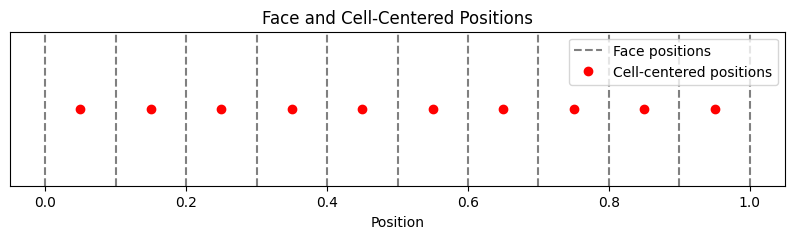

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 2))  # Adjust figure size to make it rectangular

# Plot face positions as vertical lines
for x in x_f:
    plt.axvline(x, color='gray', linestyle='--', label='Face positions' if x == x_f[0] else '')

# Plot cell-centered positions as dots
plt.plot(x_c, [0] * len(x_c), 'ro', label='Cell-centered positions')

plt.xlabel('Position')
plt.yticks([])  # Remove y-ticks
plt.gca().set_yticklabels([])  # Remove y-labels
plt.title('Face and Cell-Centered Positions')
plt.legend()
plt.show()

#### Divergence Matrix

When computing the divergence of a flux, the input consists of face-centered quantities. The `construct_div` function in `PyMRM` creates the `div_mat` matrix, which takes these face-centered quantities and computes their divergence to produce cell-centered values.

This explains why `construct_div` only requires face positions (`x_f`) as input. The resulting `div_mat` matrix maps face-centered values to cell-centered values, and its shape reflects this mapping. The shape of `div_mat` is `(n_c, n_c+1)`, where `n_c` is the number of cells in the computational domain. This means that it has `n_c` rows (one for each cell) and `n_c+1` columns (one for each face, including the boundary faces):

In [32]:
print(f'div_mat.shape = {div_mat.shape}')

div_mat.shape = (10, 11)


The `div_mat` matrix is stored in a sparse-storage format, i.e., only non-zero values are stored:

In [27]:
print(div_mat[0:4,0:4])

<Compressed Sparse Column sparse array of dtype 'float64'
	with 7 stored elements and shape (4, 4)>
  Coords	Values
  (0, 0)	-10.0
  (0, 1)	10.0
  (1, 1)	-10.0
  (1, 2)	10.0
  (2, 2)	-9.999999999999996
  (2, 3)	9.999999999999996
  (3, 3)	-10.000000000000002


In a dense storage format also all zero-values would be stored, which is a wast of computer memory and resources in computations (when multiplictions or additions with these zeros are performed).

In [28]:
print(div_mat.todense()[0:4,0:4])

[[-10.  10.   0.   0.]
 [  0. -10.  10.   0.]
 [  0.   0. -10.  10.]
 [  0.   0.   0. -10.]]


When acting on a vector, the divergence matrix will subtract to subsequent face-values and divide by the cell-width.

#### Gradients Matrix

 Quantities like gradients and fluxes are computed at the cell faces, based on the values in neighboring cells. For example:

- **Gradients**: Computed from the difference in values between two neighboring cells, divided by the distance between the centers. These are defined at the cell faces.
- **Fluxes**: Represent the transport of quantities across cell faces, often involving both convective and diffusive contributions.

The `grad_mat` matrix in `PyMRM` is used to compute gradients. It operates on cell-centered values and outputs face-centered quantities. As a result, `grad_mat` is not a square matrix. Its shape reflects the relationship between the number of cell-centered values and the number of face-centered quantities.

In [40]:
print(f'grad_mat.shape = {grad_mat.shape}\n')
print(f'sparse matrix format: \n {grad_mat[0:4,0:4]}\n')
print(f'dense matrix format: \n {grad_mat.todense()[0:4,0:4]}')

grad_mat.shape = (11, 10)

sparse matrix format: 
 <Compressed Sparse Column sparse array of dtype 'float64'
	with 8 stored elements and shape (4, 4)>
  Coords	Values
  (0, 0)	30.0
  (1, 0)	-9.999999999999998
  (0, 1)	-3.3333333333333326
  (1, 1)	9.999999999999998
  (2, 1)	-10.000000000000002
  (2, 2)	10.000000000000002
  (3, 2)	-9.999999999999996
  (3, 3)	9.999999999999996

dense matrix format: 
 [[ 30.          -3.33333333   0.           0.        ]
 [-10.          10.           0.           0.        ]
 [  0.         -10.          10.           0.        ]
 [  0.           0.         -10.          10.        ]]


#### Boundary Conditions

The gradient matrix is similar to the divergence matrix and is almost its transpose. However, the first and last rows differ due to boundary conditions. For the divergence matrix, both left and right faces of a cell are always present, making the first cell not special. In contrast, the gradient matrix computes face values based on neighboring cell values, and the first face lacks a left neighbor.

Boundary conditions in `PyMRM` follow the general form:
$$a \, \frac{\partial c}{\partial n} + b \, c = d,$$
where $n$ is the normal direction ($-x$ on the left and $+x$ on the right boundary).

This boundary condition allows for Dirichlet boundary conditions with $a=0$, Neumann boundary conditions with $b=0$, and Robin (also called mixed) boundary conditions, with both $a$ and `b` non-zero. 

For non-zero $d$, the boundary condition is inhomogeneous, introducing a vector contribution to the gradient. This contribution is non-zero only for the first and last faces and is provided as a sparse column matrix of shape `(nc+1, 1)`.

With this inhomogeneous contribution the full gradient corresponding to cell values `c` can be computed as:

```python
grad_c = grad_mat @ c + grad_bc
```
The discretized stationary diffusion equation then becomes:
```python
div_mat @ grad_c = f
div_mat @ (grad_mat @ c + grad_bc) = f
(div_mat @ grad_mat) @ c = f - div_mat @ grad_bc
lapl_mat @ c = f - div_mat @ grad_bc
```
This sparse matrix vector equation can then be solved by a `spsolve`, a direct sparse matrix solver from `Scipy`.

When comparing the code above with the implementation [Stationary Diffusion Code](#stationary-diffusion-code), you might notice some `reshape` methods being invoked.
The reason is that in `Numpy` 1D vectors can be represented with a shape: `(nc,)`, while SciPy sparse matrices always need to be 2D, also if it represents a column vector. Therefore its shape is `(nc,1)`. When in a reshpaping operation a -1 is used, Numpy will fogure out the length of this axis from the total size of the array.




#### Exercise

Reconsider the implementation of the stationary diffusion problem: [Stationary Diffusion Code](#stationary-diffusion-code).

- Set `f=0` and play around with the left and right boundary conditions, i.e. change the values of `a`, `b` and `d`.
- Confirm that the boundary condition is applied according to expectation.
- Play around with non-zero source terms `f`.
- For choices of `f` for which an analytical solution can be determined, e.g., $f = \sin(\pi x/L)$, find the analytical solution.
- Investigate the convergence behavior from of the numerical solution to the analytical one.